# Research on apartment sales ads

You will have the data from a real estate agency. It is an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. You’ll need to learn how to determine the market value of real estate properties. Your task is to define the parameters. This will make it possible to build an automated system that is capable of detecting anomalies and fraudulent activity.

There are two different types of data available for every apartment for sale. The first type is a user’s input. The second type is received automatically based upon the map data. For example, the distance from the downtown area, airport, the nearest park or body of water. 

### Step 1. Open the data file and study the general information. 

In [44]:
import pandas as pd

data = pd.read_csv('/datasets/real_estate_data_us.csv', sep="\t")
data.info()
print(data.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
date_posted          23699 non-null object
days_listed          20518 non-null float64
last_price           23699 non-null float64
bedrooms             23699 non-null int64
kitchen_area         21421 non-null float64
living_area          21796 non-null float64
total_area           23699 non-null float64
balconies            12180 non-null float64
ceiling_height       14504 non-null float64
floors_total         23613 non-null float64
floor                23699 non-null int64
total_images         23699 non-null int64
bike_parking         2775 non-null object
is_studio            23699 non-null bool
is_open_plan         23699 non-null bool
locality_name        23650 non-null object
airport_dist         18157 non-null float64
city_center_dist     18180 non-null float64
park_dist            8079 non-null float64
parks_within_3000    18181 non-null float64
pond_dist            9110 no

### Conclusion

We first parse the information from the csv file, separating lines by the tab delimiter '\t'. Taking a look at the info of the dataframe and the first few rows, we can make a couple initial observations:

* the **date_posted** column contains str objects that can be converted to a datetime objects.
* the **days_listed** contains floats, but we can convert these to ints, since we're measuring by full days. Let's assume null values mean they haven't been sold yet, so we'll change those to 0.
* the **balconies** column contains null values - we can assume these listings have no balconies, and convert these to 0s. We can't have a fraction of a balcony, so we can change this column from floats to ints as well.
* **floors_total** is a float - we can changes these to ints; we cannot have a fraction of a floor.
* the **bike_parking** column contains null values - we can assume these listings don't have bike parkings, and change these to False
* we can do the same to the **parks_within_3000 and ponds_within_3000** columns as we did to **balconies**.

Other columns with null values should be left alone (such as kitchen_area, living_area, etc)- we shouldn't assume values for these columns. If necessary, we can assign mean values to null column values if having null values interfere with data processing. Alternatively we can exclude them from our data sets.

### Step 2. Data preprocessing

In [45]:
#change type of 'date_posted' column to datetime
data['date_posted']= pd.to_datetime(data['date_posted'], format='%Y-%m-%dT%H:%M:%S')

#change types to int
data['days_listed'] = data['days_listed'].fillna(0).astype(int)
data['balconies'] = data['balconies'].fillna(0).astype(int)
data['floors_total'] = data['floors_total'].fillna(0).astype(int)
data['parks_within_3000'] = data['parks_within_3000'].fillna(0).astype(int)
data['ponds_within_3000'] = data['ponds_within_3000'].fillna(0).astype(int)

#fill null values as False
data['bike_parking'] = data['bike_parking'].fillna(False)

#check to make sure everything is alright
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
date_posted          23699 non-null datetime64[ns]
days_listed          23699 non-null int64
last_price           23699 non-null float64
bedrooms             23699 non-null int64
kitchen_area         21421 non-null float64
living_area          21796 non-null float64
total_area           23699 non-null float64
balconies            23699 non-null int64
ceiling_height       14504 non-null float64
floors_total         23699 non-null int64
floor                23699 non-null int64
total_images         23699 non-null int64
bike_parking         23699 non-null bool
is_studio            23699 non-null bool
is_open_plan         23699 non-null bool
locality_name        23650 non-null object
airport_dist         18157 non-null float64
city_center_dist     18180 non-null float64
park_dist            8079 non-null float64
parks_within_3000    23699 non-null int64
pond_dist            9110 non

### Step 3. Make calculations and add them to the table

In [77]:
#make new columns
data['price_per_sq_meter'] = data['last_price']/data['total_area']

#get day of week
days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
data['day_posted_string'] = [days[d.weekday()] for d in data['date_posted']]
data['day_posted'] = data['date_posted'].dt.day
#get month
months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data['month_string'] = [months[m-1] for m in data['date_posted'].dt.month]
data['month'] = data['date_posted'].dt.month
#get year
data['year'] = data['date_posted'].dt.year

#floor position
def check_floor(floor, total):
    if floor == total:
        return 'last'
    elif floor == 1:
        return 'first'
    else:
        return 'other'
data['floor_pos'] = [check_floor(f,t) for f, t in data[['floor', 'floors_total']].itertuples(index=False)]

#kitchen and living ratios
living_not_null = data.query('living_area != "NaN"')
data['living_ratio'] = data['living_area']/data['total_area']

kitchen_not_null = data.query('kitchen_area != "NaN"')
data['kitchen_area'] = data['kitchen_area']/data['total_area']

#check to make sure we have the new columns
print(data.head(5))




  date_posted  days_listed  last_price  bedrooms  kitchen_area  living_area  \
0  2019-03-07            0    260000.0         3      0.000020         51.0   
1  2018-12-04           81     67000.0         1      0.000167         18.6   
2  2015-08-20          558    103920.0         2      0.000047         34.3   
3  2015-07-24          424   1298000.0         3           NaN          NaN   
4  2018-06-19          121    200000.0         2      0.000041         32.0   

   total_area  balconies  ceiling_height  floors_total  ...  \
0       108.0          0            2.70            16  ...   
1        40.4          2             NaN            11  ...   
2        56.0          0             NaN             5  ...   
3       159.0          0             NaN            14  ...   
4       100.0          0            3.03            14  ...   

   ponds_within_3000  price_per_sq_meter  day_posted  month  year floor_pos  \
0                  2         2407.407407    Thursday      3  2019  

### Step 4. Conduct exploratory data analysis and follow the instructions below:

Mean before removing outliers:  156.60884425503187
Median before removing outliers:  74.0


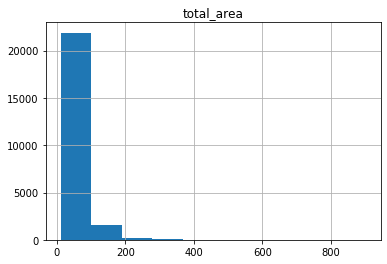

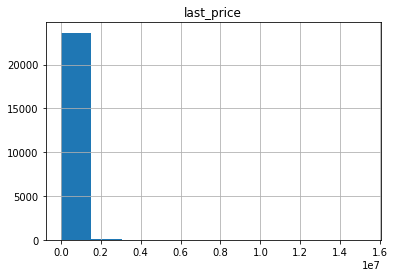

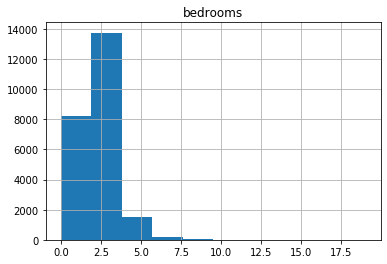

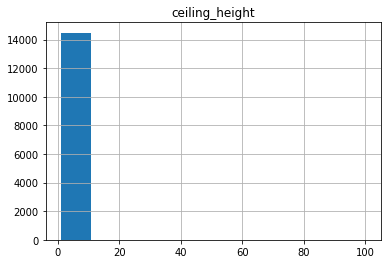

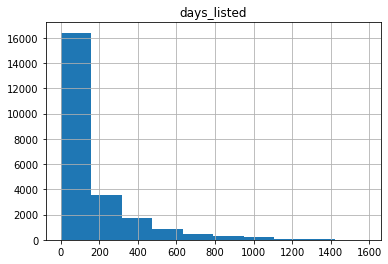

In [47]:
#histogram for square area
data.hist('total_area')

#histogram for price
data.hist('last_price')

#histogram for number of rooms
data.hist('bedrooms')

#histogram for ceiling height
data.hist('ceiling_height')

#histogram for time taken to sell listing
data.hist('days_listed')

print('Mean before removing outliers: ', data['days_listed'].mean())
print('Median before removing outliers: ', data['days_listed'].median())

#### Preliminary remarks

Looking at the data, it's difficult to make any conclusions due to outliers having such a large effect histograms. We'll remove these outliers to extract more meaningful information from our data.

Preliminary findings shot that the majority of the sales are made within the first ~150 days of listing, 
with the mean being ~156 days, probably due to outliers. 

we'll use the formulas (IQR*1.5 + Q3) and (Q1 - IQR*1.5) to determine the outliers.

Any sale longer than 464.5 days(Q3) can be considered extra long.

Mean after removing outliers:  100.96745536106957
Median after removing outliers:  60.0


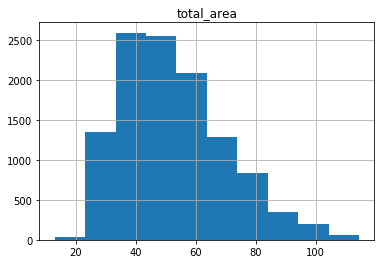

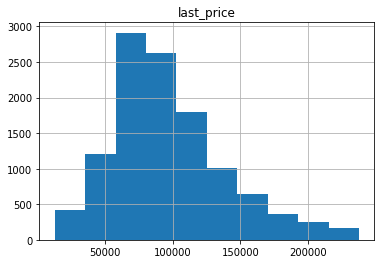

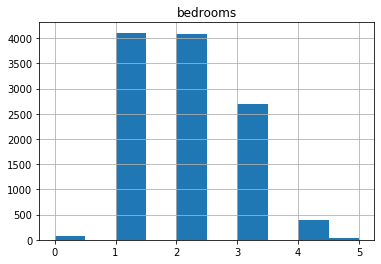

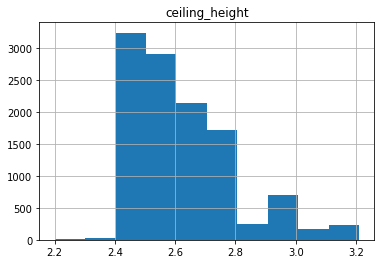

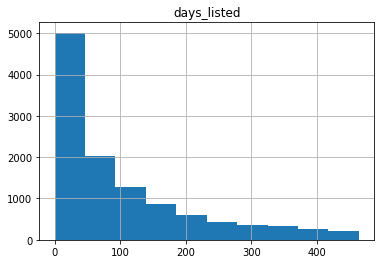

In [79]:
'''
we'll define a function that :
1. finds the interquartile range
2. determines the low/high fences
3. creates a map containing col_names as keys, and low/high fences as the values
4. removes outliers for each column based on the fences in the map
5. returns a processed new dataframe 
'''
from collections import defaultdict
def remove_outlier(df_in, col_names):
    fence_map = defaultdict(list)
    for name in col_names:
        q1 = df_in[name].quantile(0.25)
        q3 = df_in[name].quantile(0.75)
        iqr = q3-q1 
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        fence_map[name] = (fence_low, fence_high)
    df_out = df_in
    for k, v in fence_map.items():
        df_out = df_out.loc[(df_out[k] > v[0]) & (df_out[k] < v[1])]
    return df_out

#remove outliers
parameters = ['total_area','last_price','bedrooms','ceiling_height','days_listed', 'price_per_sq_meter']
cleansed_data = remove_outlier(data, parameters)

#histogram for square area
cleansed_data.hist('total_area')

#histogram for price
cleansed_data.hist('last_price')

#histogram for number of rooms
cleansed_data.hist('bedrooms')

#histogram for ceiling height
cleansed_data.hist('ceiling_height')

#histogram for time taken to sell listing
cleansed_data.hist('days_listed')
print('Mean after removing outliers: ', cleansed_data['days_listed'].mean())
print('Median after removing outliers: ', cleansed_data['days_listed'].median())



#### Secondary remarks

After processing our data and removing outliers, the data we see from the histograms become much more meaningful.

We can see that removing the outliers causes a significant change in the average days listed, moving the mean to approximately 100. The median also slightly shifts to 60 days.

,price_per_sq_meter,bedrooms,city_center_dist
price_per_sq_meter,1.000000,-0.235571,-0.385523
bedrooms,-0.235571,1.000000,-0.056436
city_center_dist,-0.385523,-0.056436,1.000000


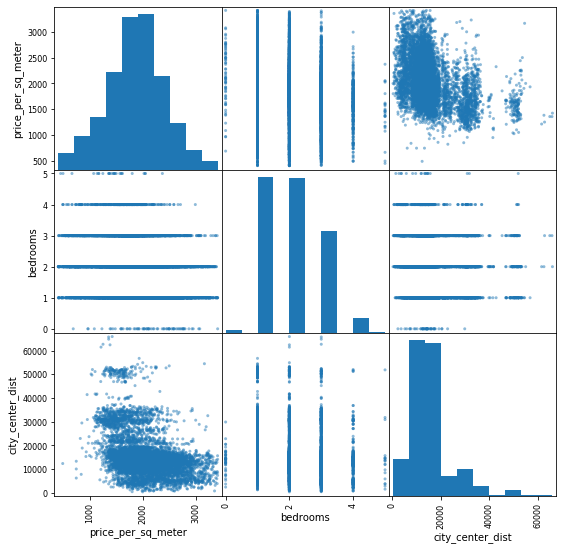

In [74]:
correlation_data = cleansed_data[['price_per_sq_meter', 'bedrooms', 'floor_pos', 'city_center_dist']]

pd.plotting.scatter_matrix(correlation_data, figsize=(9,9))
correlation_data.corr()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11369 entries, 4 to 23698
Data columns (total 30 columns):
date_posted           11369 non-null datetime64[ns]
days_listed           11369 non-null int64
last_price            11369 non-null float64
bedrooms              11369 non-null int64
kitchen_area          10639 non-null float64
living_area           10756 non-null float64
total_area            11369 non-null float64
balconies             11369 non-null int64
ceiling_height        11369 non-null float64
floors_total          11369 non-null int64
floor                 11369 non-null int64
total_images          11369 non-null int64
bike_parking          11369 non-null bool
is_studio             11369 non-null bool
is_open_plan          11369 non-null bool
locality_name         11362 non-null object
airport_dist          8806 non-null float64
city_center_dist      8813 non-null float64
park_dist             3625 non-null float64
parks_within_3000     11369 non-null int64
pond_dist  

,price_per_sq_meter,day_posted,month,year
price_per_sq_meter,1.000000,0.000454,-0.014100,0.119328
day_posted,0.000454,1.000000,-0.019465,-0.010016
month,-0.014100,-0.019465,1.000000,-0.354519
year,0.119328,-0.010016,-0.354519,1.000000


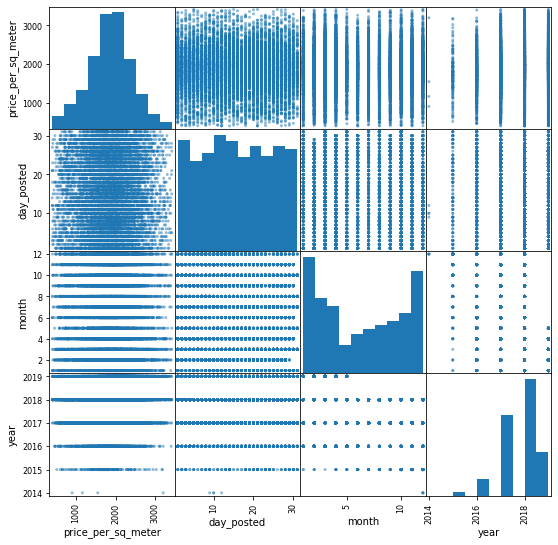

In [7]:
correlation_data2 = cleansed_data[['price_per_sq_meter', 'day_posted', 'month', 'year']]
pd.plotting.scatter_matrix(correlation_data2, figsize=(9,9))
correlation_data2.corr()

Judging from the scatter plots and the correlation matrix, there aren't any strong correlations between price per square meter and other variables.

In [29]:
#find the 10 places with most number of ads
grouped_data = cleansed_data['locality_name'].value_counts()
top_10 = grouped_data.head(10)

#here we can see the locations with the most ads
print(top_10)

#create a list of the top 10
top_10_list = top_10.index.values

#filter our dataframe using the list
top_10_data = cleansed_data.query('locality_name in @top_10_list')

#sort our dataframe by price per square meter
top_10_data.groupby('locality_name').mean().sort_values('price_per_sq_meter')



Saint Petersburg     7552
Vsevolozhsk           241
Shushary village      200
Murino village        188
Kolpino               187
Pushkin               183
Gatchina              131
Pargolovo village     131
Petergof              120
Kudrovo village       105
Name: locality_name, dtype: int64


,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,floor,...,city_center_dist,park_dist,parks_within_3000,pond_dist,ponds_within_3000,price_per_sq_meter,day_posted,month,year,living_ratio
locality_name,,,,,,,,,,,,,,,,,,,,,
Vsevolozhsk,117.979253,76179.763485,1.962656,0.190106,31.582478,57.236307,0.883817,2.667427,8.585062,4.784232,...,NaN,NaN,0.000000,NaN,0.000000,1343.253992,14.954357,6.630705,2017.622407,0.543362
Gatchina,103.557252,71487.030534,1.938931,0.165717,30.192583,50.548092,0.954198,2.613893,6.114504,3.458015,...,NaN,NaN,0.000000,NaN,0.000000,1415.210213,15.931298,5.969466,2017.656489,0.591663
Kolpino,91.850267,77302.106952,2.122995,0.171404,31.253702,52.424706,0.673797,2.597005,8.914439,5.149733,...,32174.363636,446.815385,0.459893,564.336538,0.919786,1513.956578,15.647059,6.021390,2017.705882,0.588615
Shushary village,115.745000,84232.920000,1.890000,0.209140,30.010052,54.533100,0.805000,2.640350,10.560000,5.785000,...,25416.449495,NaN,0.000000,603.051724,0.290000,1594.669030,15.905000,6.460000,2017.545000,0.537521
Petergof,108.533333,80352.333333,1.833333,0.166194,28.252393,47.958083,0.466667,2.593167,5.991667,3.558333,...,35529.875000,408.941860,1.341667,536.464789,1.316667,1678.331843,16.758333,5.750000,2017.566667,0.583545
Murino village,110.117021,78417.904255,1.473404,0.253156,23.646851,45.997021,1.191489,2.695160,19.468085,10.675532,...,NaN,NaN,0.000000,NaN,0.000000,1754.286893,15.936170,6.659574,2017.558511,0.500864
Pargolovo village,98.679389,89767.328244,1.580153,0.243634,25.126562,50.847099,0.893130,2.630458,20.961832,11.213740,...,20189.007634,304.750000,0.030534,489.636364,0.267176,1813.451447,16.389313,6.404580,2017.496183,0.474262
Kudrovo village,109.704762,85817.466667,1.523810,0.252226,24.747000,48.382286,1.000000,2.729143,18.876190,9.504762,...,NaN,NaN,0.000000,NaN,0.000000,1825.225794,15.028571,5.600000,2017.085714,0.511595
Pushkin,115.240437,101705.754098,1.825137,0.179769,29.588613,50.906284,0.502732,2.642131,5.005464,2.786885,...,28727.697802,404.206186,0.628415,508.294118,0.770492,2004.248066,15.311475,6.213115,2017.573770,0.570244


Here we can see that Vsevolozhsk has the lowest average price per square meter, and Saint Petersburg has the highest price per square meter.

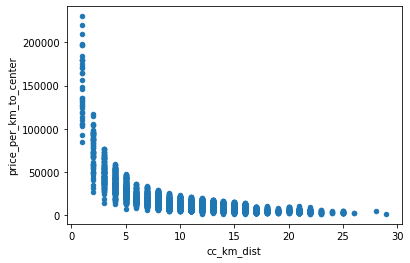

In [44]:
#select apartments in Saint Petersburg
sp_data = cleansed_data[cleansed_data['locality_name']=='Saint Petersburg'].copy()

sp_data['cc_km_dist'] = sp_data['city_center_dist']//1000
sp_data['price_per_km_to_center'] = sp_data['last_price']/sp_data['cc_km_dist']
sp_data.plot(x = 'cc_km_dist', y = 'price_per_km_to_center', kind='scatter')

Looking at the graph, we can see that price range drastically between 1-5km to the city center, and stabilizes around 6+ km from the city center. We'll mark 6 km as the maximum distance for a location to be considered 'downtown'.

,total_area,last_price,bedrooms,ceiling_height,cc_km_dist
total_area,1.000000,0.722911,0.802745,0.264028,-0.052297
last_price,0.722911,1.000000,0.481036,0.189123,-0.063162
bedrooms,0.802745,0.481036,1.000000,0.211196,-0.103695
ceiling_height,0.264028,0.189123,0.211196,1.000000,-0.114411
cc_km_dist,-0.052297,-0.063162,-0.103695,-0.114411,1.000000


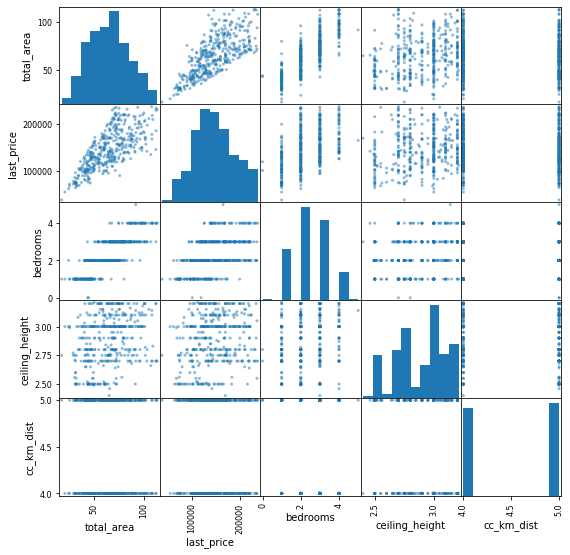

In [48]:
#we'll take a slice between 3 km and 6 km from the center, as variance is significantly less than 0-3km.
downtown_slice = sp_data.query('cc_km_dist > 3 & cc_km_dist < 6')[['total_area', 'last_price', 'bedrooms', 'ceiling_height','floor_pos','cc_km_dist']]
pd.plotting.scatter_matrix(downtown_slice, figsize=(9,9))
downtown_slice.corr()

Looking at the scatter plots and correlation matrix, there is a strong positive trend in this segment of the downtown area between price and total area. Additionally, there is a weaker positive trend between price and bedrooms.

### Step 5. Overall conclusion

Based on the data that we studied, drawing correlations between columns in a massive dataset is nearly impossible, even after removing outlying data. Removing outlying data helps us in extracting useful data from the histograms produced for each column, but we need to parse the data further to make some conclusions. We only found correlations between different columns after removing outliers, and narrowing our data to a specific location, in a segment of our downtown area.